In [1]:
# !pip install catboost

In [2]:
# !pip install ml_metrics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
merged = pd.read_csv('data/merged_data.csv', index_col=None)
merged.head()

D:\programs\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
0,0,139128,1050,97633689,236.89,1,0.0,5045454,3573,122,119,-1,-1,-1,-1,-1,-1,-1
1,1,139128,1050,97633791,178.16,1,0.0,73719,5154,122,119,-1,-1,-1,-1,-1,-1,-1
2,2,139128,1050,97635201,173.28,1,0.0,7000939,2846,85,84,-1,-1,-1,-1,-1,-1,-1
3,3,139128,1050,97635312,73.69,1,0.0,7386015,3342,85,84,-1,-1,-1,-1,-1,-1,-1
4,4,139128,1050,97635414,282.14,1,0.0,73291,2846,85,84,-1,-1,-1,-1,-1,-1,-1


In [3]:
print(merged['user_id'].nunique())
print(merged['product_id'].nunique())
print(len(merged))

merged = merged[merged['product_id'] != 0]
print(len(merged))

107068
91994
21677070
21466723


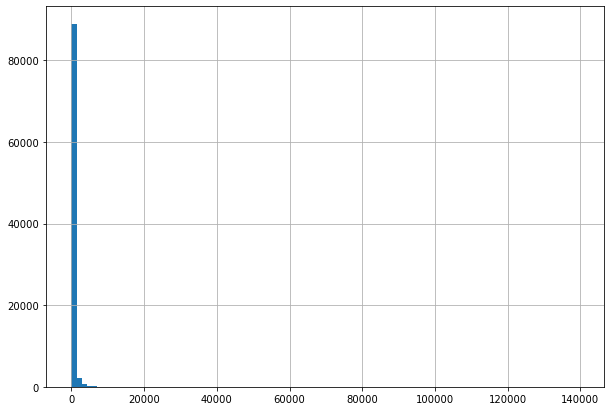

In [4]:
plt.figure(figsize=(10, 7))
merged['product_id'].value_counts().hist(bins=100)

In [5]:
merged['user_id'].nunique()

107066

In [6]:
groupby_0 = pd.DataFrame({'count' : merged.groupby(['product_id']).size()}).reset_index()
groupby_0 = groupby_0.sort_values(['count'], ascending=False)
groupby_0.head(3)

,product_id,count
193,709,139570
9290,39590,44804
71,166,36970


In [7]:
# доля покрытия
print(groupby_0[:1000]['count'].sum() / groupby_0['count'].sum())
print(groupby_0[:15000]['count'].sum() / groupby_0['count'].sum())
print(groupby_0[:35000]['count'].sum() / groupby_0['count'].sum())

0.28358841729126516
0.8288523124838384
0.9561352238066332


In [8]:
# фильтруем по продуктам
top_products = groupby_0[:35000]['product_id'].tolist()

merged = merged[merged['product_id'].isin(top_products)]
print(len(merged))
print(merged['user_id'].nunique())

20525090
106936


In [9]:
users_n_orders = merged.groupby(['user_id'])['order_id'].nunique().to_frame('count').reset_index()
users_n_orders.head(3)

,user_id,count
0,51,17
1,65,23
2,187,1


In [10]:
valid_users = users_n_orders[users_n_orders['count'] >= 2]
valid_users_ids = valid_users['user_id'].tolist()
print('valid_users_ids', len(valid_users_ids))

merged = merged[merged['user_id'].isin(valid_users_ids)]
print(len(merged))

valid_users_ids 86924
20094509


In [11]:
merged_ = merged[merged['order_created_time'].values != -1]
merged_ = merged_[merged_['order_created_time'].values != '-1']
merged_ = merged_.drop(columns=['Unnamed: 0']) 

# Change data types to reduce memory footprint
merged_ = merged_.astype({
    'user_id': 'int32',
    'order_id': 'int32',
    'price': 'float32',
    'quantity': 'int32',
    'discount': 'float32',
    'product_id': 'int32',
    'brand_name': 'int32',
    'master_category_id': 'int32',
    'parent_category_id': 'int32',
    'order_created_time': str,
    'retailer': 'int32',
    'platform': 'int32',
    'city_name': 'int32',
    'gender': 'int32',
    'age': 'int32'}, copy=False)

merged_['order_created_time'] = pd.to_datetime(merged_['order_created_time'], format='%Y-%m-%d %H:%M:%S', exact=True)

In [12]:
del merged

In [13]:
merged_.head(3)

,order_id,user_id,line_item_id,price,quantity,discount,product_id,brand_name,master_category_id,parent_category_id,order_created_time,retailer,platform,city_name,gender,bdate,age
282503,5531326,691783,28336408,40.000000,1,6.990000,67693,700,577,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282504,5531326,691783,28336410,139.000000,1,106.000000,1536,815,582,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22
282505,5531326,691783,28336411,49.900002,1,39.990002,57951,104,581,9,2019-12-31 21:29:17,4,0,71,1,1998-06-20 00:00:00,22


In [14]:
features = merged_.groupby(['user_id', 'product_id', 'master_category_id', 
                            'parent_category_id']).agg(
    product_count=pd.NamedAgg(column='product_id', aggfunc='count'),
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
    last_date_purchase=pd.NamedAgg(column='order_created_time', aggfunc='max'),
).reset_index()
            
features.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,last_date_purchase
0,400,41,85,84,1,0.000,0.00,0.0,59.000000,59.000000,59.000000,2020-06-19 11:57:25
1,400,177,26,20,2,9.995,19.99,0.0,64.895004,74.889999,54.900002,2020-07-09 12:01:19
2,400,397,38,35,1,139.000,139.00,139.0,265.000000,265.000000,265.000000,2020-06-29 19:14:42


In [15]:
# add user properities

# средний размер корзины
users_info_0 = merged_.groupby(['user_id', 'order_id']).agg(
    orders_size=pd.NamedAgg(column='product_id', aggfunc='count'),
).reset_index()

users_info_1 = users_info_0.groupby(['user_id']).agg(
    avg_order_size=pd.NamedAgg(column='orders_size', aggfunc='mean'),
).reset_index()

users_info = merged_.groupby(['user_id']).agg(
    orders_count=pd.NamedAgg(column='order_id', aggfunc='count'),
    last_order_date=pd.NamedAgg(column='order_created_time', aggfunc='max'),
    first_order_date=pd.NamedAgg(column='order_created_time', aggfunc='min'),
    freq_retailer=pd.NamedAgg(column='retailer', aggfunc=lambda x:x.value_counts().index[0]), # mode
).reset_index()

users_info = pd.merge(users_info, users_info_1, on='user_id')
users_info.head(3)

,user_id,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size
0,400,129,2020-07-09 12:01:19,2020-06-13 13:26:03,4,25.80
1,576,146,2020-09-04 17:33:47,2020-06-26 08:05:37,4,18.25
2,608,58,2020-08-29 05:52:55,2020-08-04 16:30:07,4,14.50


In [16]:
# categories properities
categories = merged_.groupby(['master_category_id', 'parent_category_id']).agg(
    all_product_counts=pd.NamedAgg(column='product_id', aggfunc='count'),
    max_price_of_product=pd.NamedAgg(column='price', aggfunc='max'),
).reset_index()

categories.head(3)

,master_category_id,parent_category_id,all_product_counts,max_price_of_product
0,15,9,159438,3671.0
1,16,9,32209,3282.0
2,21,20,331432,154.0


In [17]:
# product properities
products = merged_.groupby(['product_id', 'master_category_id', 'parent_category_id']).agg(
    product_count_in_categ=pd.NamedAgg(column='product_id', aggfunc='count'),   
    avg_discount=pd.NamedAgg(column='discount', aggfunc='mean'),
    max_discount=pd.NamedAgg(column='discount', aggfunc='max'),
    min_discount=pd.NamedAgg(column='discount', aggfunc='min'),
    avg_price=pd.NamedAgg(column='price', aggfunc='mean'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),
).reset_index()

products.head(3)

,product_id,master_category_id,parent_category_id,product_count_in_categ,avg_discount,max_discount,min_discount,avg_price,max_price,min_price
0,6,22,20,75,8.238267,17.389999,0.0,46.686401,57.790001,39.900002
1,8,22,20,243,8.517366,17.389999,0.0,46.150124,61.599998,37.799999
2,9,22,20,114,10.388772,18.639999,0.0,45.386669,59.090000,38.009998


In [18]:
products_and_cat = pd.merge(products, categories, on=['master_category_id', 'parent_category_id'])

products_and_cat['freq_of_buying'] = products_and_cat['product_count_in_categ'] / products_and_cat['all_product_counts']
products_and_cat['avg_quantile'] = products_and_cat['avg_price'] / products_and_cat['max_price_of_product']
products_and_cat['max_quantile'] = products_and_cat['max_price'] / products_and_cat['max_price_of_product']
products_and_cat['min_quantile'] = products_and_cat['min_price'] / products_and_cat['max_price_of_product']

products_and_cat.head(3)

,product_id,master_category_id,parent_category_id,product_count_in_categ,avg_discount,max_discount,min_discount,avg_price,max_price,min_price,all_product_counts,max_price_of_product,freq_of_buying,avg_quantile,max_quantile,min_quantile
0,6,22,20,75,8.238267,17.389999,0.0,46.686401,57.790001,39.900002,113422,165.770004,0.000661,0.281634,0.348616,0.240695
1,8,22,20,243,8.517366,17.389999,0.0,46.150124,61.599998,37.799999,113422,165.770004,0.002142,0.278399,0.371599,0.228027
2,9,22,20,114,10.388772,18.639999,0.0,45.386669,59.090000,38.009998,113422,165.770004,0.001005,0.273793,0.356458,0.229294


In [19]:
features_for_test = pd.merge(features, users_info, on='user_id')
features_for_test['17_sep_date'] = pd.Timestamp('2020-09-17 00:00:00')

features_for_test['product_purchase_share'] = features_for_test['product_count'] / features_for_test['orders_count']
features_for_test['last_order_days_ago'] = features_for_test['17_sep_date'] - features_for_test['last_order_date']
features_for_test['first_order_days_ago'] = features_for_test['17_sep_date'] - features_for_test['first_order_date']
features_for_test['last_purchase_days_ago'] = features_for_test['17_sep_date'] - features_for_test['last_date_purchase']

features_for_test['last_order_days_ago'] = features_for_test['last_order_days_ago'].dt.days
features_for_test['first_order_days_ago'] = features_for_test['first_order_days_ago'].dt.days
features_for_test['last_purchase_days_ago'] = features_for_test['last_purchase_days_ago'].dt.days

features_for_test.tail(4)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,orders_count,last_order_date,first_order_date,freq_retailer,avg_order_size,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago
13326677,3142407,5061149,234,232,1,0.0,0.0,0.0,52.990002,52.990002,...,35,2020-09-16 19:52:23,2020-09-15 16:07:24,13,17.5,2020-09-17,0.028571,0,1,1
13326678,3142407,5076176,247,243,1,0.0,0.0,0.0,801.989990,801.989990,...,35,2020-09-16 19:52:23,2020-09-15 16:07:24,13,17.5,2020-09-17,0.028571,0,1,1
13326679,3142407,5566924,260,252,1,0.0,0.0,0.0,270.989990,270.989990,...,35,2020-09-16 19:52:23,2020-09-15 16:07:24,13,17.5,2020-09-17,0.028571,0,1,1
13326680,3142407,7034722,280,279,1,0.0,0.0,0.0,35.990002,35.990002,...,35,2020-09-16 19:52:23,2020-09-15 16:07:24,13,17.5,2020-09-17,0.028571,0,1,1


In [20]:
# replace Nans where possible

features_for_test['product_purchase_share'] = features_for_test['product_purchase_share'].fillna(0)
features_for_test['product_count'] = features_for_test['product_count'].fillna(0)

features_for_test = pd.merge(features_for_test, 
                 products_and_cat[['product_id', 'master_category_id', 
                                   'parent_category_id', 'freq_of_buying', 
                                   'avg_quantile', 'max_quantile', 'min_quantile']], 
                 on=['product_id', 'master_category_id', 'parent_category_id'],
                how='left')

features_for_test = features_for_test.sort_values('user_id')

features_for_test['freq_of_buying'] = features_for_test['freq_of_buying'].fillna(0)
features_for_test['avg_quantile'] = features_for_test['avg_quantile'].fillna(0)
features_for_test['max_quantile'] = features_for_test['max_quantile'].fillna(0)
features_for_test['min_quantile'] = features_for_test['min_quantile'].fillna(0)

features_for_test.head(3)

,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,avg_order_size,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile
0,400,41,85,84,1,0.0,0.0,0.0,59.000000,59.000000,...,25.8,2020-09-17,0.007752,69,95,89,0.000646,0.000102,0.000589,0.000004
79,400,3817489,85,84,1,0.0,0.0,0.0,190.460007,190.460007,...,25.8,2020-09-17,0.007752,69,95,89,0.014428,0.000430,0.003224,0.000000
78,400,3817484,85,84,2,0.0,0.0,0.0,45.349998,50.000000,...,25.8,2020-09-17,0.015504,69,95,89,0.019156,0.000080,0.001039,0.000004


In [21]:
features_for_test.isnull().any()

user_id                   False
product_id                False
master_category_id        False
parent_category_id        False
product_count             False
avg_discount              False
max_discount              False
min_discount              False
avg_price                 False
max_price                 False
min_price                 False
last_date_purchase        False
orders_count              False
last_order_date           False
first_order_date          False
freq_retailer             False
avg_order_size            False
17_sep_date               False
product_purchase_share    False
last_order_days_ago       False
first_order_days_ago      False
last_purchase_days_ago    False
freq_of_buying            False
avg_quantile              False
max_quantile              False
min_quantile              False
dtype: bool

In [22]:
len(features), len(features_for_test)

(13326681, 13326681)

In [23]:
features_for_test.columns

Index(['user_id', 'product_id', 'master_category_id', 'parent_category_id',
       'product_count', 'avg_discount', 'max_discount', 'min_discount',
       'avg_price', 'max_price', 'min_price', 'last_date_purchase',
       'orders_count', 'last_order_date', 'first_order_date', 'freq_retailer',
       'avg_order_size', '17_sep_date', 'product_purchase_share',
       'last_order_days_ago', 'first_order_days_ago', 'last_purchase_days_ago',
       'freq_of_buying', 'avg_quantile', 'max_quantile', 'min_quantile'],
      dtype='object')

In [24]:
features_for_test['GroupId'] = features_for_test['user_id'].apply(str)

# train_labels = train['target']
# train = train.drop(columns=['target'])

print(len(set(features_for_test['GroupId'])))
features_for_test.head(3)

84405


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,17_sep_date,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile,GroupId
0,400,41,85,84,1,0.0,0.0,0.0,59.000000,59.000000,...,2020-09-17,0.007752,69,95,89,0.000646,0.000102,0.000589,0.000004,400
79,400,3817489,85,84,1,0.0,0.0,0.0,190.460007,190.460007,...,2020-09-17,0.007752,69,95,89,0.014428,0.000430,0.003224,0.000000,400
78,400,3817484,85,84,2,0.0,0.0,0.0,45.349998,50.000000,...,2020-09-17,0.015504,69,95,89,0.019156,0.000080,0.001039,0.000004,400


In [25]:
features_for_test.to_csv('features_v17.csv')

In [26]:
features_for_test.dtypes

user_id                            int64
product_id                         int64
master_category_id                 int64
parent_category_id                 int64
product_count                      int64
avg_discount                     float32
max_discount                     float32
min_discount                     float32
avg_price                        float32
max_price                        float32
min_price                        float32
last_date_purchase        datetime64[ns]
orders_count                       int64
last_order_date           datetime64[ns]
first_order_date          datetime64[ns]
freq_retailer                      int32
avg_order_size                   float64
17_sep_date               datetime64[ns]
product_purchase_share           float64
last_order_days_ago                int64
first_order_days_ago               int64
last_purchase_days_ago             int64
freq_of_buying                   float64
avg_quantile                     float32
max_quantile    

### Модель


In [58]:
import ml_metrics as metrics
from catboost import CatBoost, CatBoostClassifier, Pool

In [59]:
train_final.dtypes

user_id                     int64
product_id                  int64
master_category_id        float64
parent_category_id        float64
product_count             float64
avg_discount              float32
max_discount              float32
min_discount              float32
avg_price                 float32
max_price                 float32
min_price                 float32
target                    float64
orders_count                int64
freq_retailer               int32
avg_order_size            float64
product_purchase_share    float64
last_order_days_ago         int64
first_order_days_ago        int64
last_purchase_days_ago    float64
freq_of_buying            float64
avg_quantile              float32
max_quantile              float32
min_quantile              float32
dtype: object

In [60]:
train_final = train_final.astype({
    'master_category_id' : 'int32', 
    'parent_category_id' : 'int32',
    'last_order_days_ago' : 'int32', 
    'first_order_days_ago' : 'int32',
    'target' : 'int32',
    'product_count' : 'int32',
    'user_id' : 'int32',
    'product_id' : 'int32',
})

train_final.dtypes

user_id                     int32
product_id                  int32
master_category_id          int32
parent_category_id          int32
product_count               int32
avg_discount              float32
max_discount              float32
min_discount              float32
avg_price                 float32
max_price                 float32
min_price                 float32
target                      int32
orders_count                int64
freq_retailer               int32
avg_order_size            float64
product_purchase_share    float64
last_order_days_ago         int32
first_order_days_ago        int32
last_purchase_days_ago    float64
freq_of_buying            float64
avg_quantile              float32
max_quantile              float32
min_quantile              float32
dtype: object

In [61]:
train_final['GroupId'] = train_final['user_id'].apply(str)

# train_labels = train['target']
# train = train.drop(columns=['target'])

print(len(set(train_final['GroupId'])))
train_final.head(3)

83677


,user_id,product_id,master_category_id,parent_category_id,product_count,avg_discount,max_discount,min_discount,avg_price,max_price,...,avg_order_size,product_purchase_share,last_order_days_ago,first_order_days_ago,last_purchase_days_ago,freq_of_buying,avg_quantile,max_quantile,min_quantile,GroupId
0,400,41,85,84,1,0.00,0.00,0.00,59.000000,59.000000,...,26.75,0.009346,79,95,89.0,0.000717,0.000102,0.000589,0.000004,400
43,400,67549,60,56,1,30.10,30.10,30.10,39.900002,39.900002,...,26.75,0.009346,79,95,79.0,0.002446,0.056352,0.105905,0.000000,400
44,400,69033,76,74,2,14.79,14.79,14.79,26.900000,26.900000,...,26.75,0.018692,79,95,95.0,0.005067,0.054150,0.088318,0.046210,400


In [62]:
train_final.to_csv('train_v6.csv')

### ДАЛЬШЕ НЕ ЧИТАТЬ ЭТО АППЕНДИКС))))

In [36]:
def calculate_mapk(predictions, test=True):
    if test:
        res = train.iloc[train_size: train_size + test_size]
    else:
        res = train.iloc[:train_size]
    
    res.loc[:, 'pred'] = predictions
    res = res.sort_values(['user_id', 'pred'], ascending=False)

    predicted_lists = res.groupby('user_id')['product_id'].apply(list)

    if test:
        actual_lists = res[train_labels.iloc[train_size: train_size + test_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 
    else:
        actual_lists = res[train_labels.iloc[:train_size] == 1].groupby('user_id')['product_id'].apply(list)
        actual_lists = [l[:50] for l in actual_lists.tolist()] 

    return metrics.mapk(actual_lists, predicted_lists.tolist(), 50)
    

In [37]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model = CatBoost(param)
train_size = int(len(train) * 0.1)
test_size = int(len(train) * 0.1)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
test_pool = Pool(
    data=train.iloc[train_size: train_size + test_size], 
    label=train_labels.iloc[train_size: train_size + test_size], 
    group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
model.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

predictions = model.predict(test_pool)
print('test auc', roc_auc_score(test_pool.get_label(), predictions))
print('test MAP@k', calculate_mapk(predictions, True))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=2]=85.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [71]:
importances = model.get_feature_importance(train_pool)

In [78]:
for name, importance in sorted(zip(model.feature_names_, importances), key=lambda x: x[1], reverse=True):
    # print("%s, %.8f" % (f, importances[i]))
    print(f'{name}, {importance:.8f}')

product_count, 0.02632665
product_id, 0.01084888
max_discount, 0.00086650
master_category_id, 0.00029641
avg_discount, 0.00009950
min_discount, 0.00004216
min_price, 0.00002497
max_price, 0.00000603
user_id, 0.00000000
avg_price, 0.00000000
GroupId, 0.00000000
parent_category_id, -0.00007575


### Submit

In [ ]:
%%time
param = {
    'iterations': 50, 
    'task_type': 'CPU', 
    'loss_function': 'YetiRank',
    'cat_features': ['master_category_id', 'parent_category_id', 'product_id'],
}
model_2 = CatBoost(param)
train_size = len(train)
# test_size = int(len(train) * 0.3)
train_pool = Pool(
    data=train.iloc[:train_size], 
    label=train_labels.iloc[:train_size], 
    group_id=train.iloc[:train_size]['GroupId'],
    cat_features=['master_category_id', 'parent_category_id', 'product_id'],
)
# test_pool = Pool(
#     data=train.iloc[train_size: train_size + test_size], 
#     label=train_labels.iloc[train_size: train_size + test_size], 
#     group_id=train.iloc[train_size: train_size + test_size]['GroupId'],
#     cat_features=['master_category_id', 'parent_category_id', 'product_id'],
# )
model_2.fit(train_pool, verbose=0, plot=True)

from sklearn.metrics import roc_auc_score

predictions = model_2.predict(train_pool)
print('train auc', roc_auc_score(train_pool.get_label(), predictions))
print('train MAP@k', calculate_mapk(predictions, False))

# predictions = model_2.predict(test_pool)
# print('test auc', roc_auc_score(test_pool.get_label(), predictions))
# print('test MAP@k', calculate_mapk(predictions, True))

In [ ]:
#